In [1]:
%load_ext jupyternotify
from pytket import Circuit, Qubit, Bit, OpType
from pytket.utils.operators import QubitPauliOperator
from sympy import symbols
from openfermion import QubitOperator
from random import sample
import numpy as np
from pytket.backends.projectq import ProjectQBackend
from pytket.backends.ibm import AerStateBackend, AerBackend, AerUnitaryBackend, IBMQBackend
from scipy.linalg import expm, sinm, cosm
from sympy.physics.quantum.dagger import Dagger
import functools
import operator
import itertools    
from openfermion import get_sparse_operator
from scipy.optimize import minimize, LinearConstraint
import matplotlib.pyplot as plt
import cirq

backend = AerStateBackend()

def fidelity(rsv, gsv):
    
    rsv_conj = np.conj(rsv)
    fid = sum(rsv_conj*gsv) * np.conj(sum(rsv_conj*gsv))
    
    return fid

#-----constances
n = 1
lamb = np.float(2)
s = np.exp(-1 / (2 * lamb)) - 1
cst1 = (s / 2 + 1) ** 2
cst2 = (s / 2) * (s / 2 + 1)
cst3 = (s / 2) ** 2

<IPython.core.display.Javascript object>

In [2]:
def real(n, weights):
    
    real_circ = Circuit()
    qubits = real_circ.add_q_register('q', n)

    real_circ.Rx(weights[0], qubits[0])
        
    real_circ.Ry(weights[1], qubits[0])
        
    real_circ.Rz(weights[2], qubits[0])
        

    backend.compile_circuit(real_circ)
    state_handle = backend.process_circuit(real_circ)
    statevector = backend.get_state(state_handle)
    
    return real_circ, statevector


In [3]:
def generator(n, weights):
    
    generator_circ = Circuit()
    qubits = generator_circ.add_q_register('q', n)

    generator_circ.Rx(weights[0], qubits[0])

    generator_circ.Ry(weights[1], qubits[0])

    generator_circ.Rz(weights[2], qubits[0])
        
    backend.compile_circuit(generator_circ)
    state_handle = backend.process_circuit(generator_circ)
    statevector = backend.get_state(state_handle)
    
    return generator_circ, statevector


In [4]:
def discriminator(disc_weights, real_circ, real_sv, gen_circ, gen_sv):

    disc_weights_phi = disc_weights[:len(disc_weights)//2]
    disc_weights_psi = disc_weights[len(disc_weights)//2:]

    tuple_list_phi = [(weight, tup[0], tup[1]) for weight, tup in zip(disc_weights_phi, itertools.product(['X', 'Y', 'Z'], range(n)))]
    tuple_list_psi = [(weight, tup[0], tup[1]) for weight, tup in zip(disc_weights_psi, itertools.product(['X', 'Y', 'Z'], range(n)))]

    measurements_phi =  functools.reduce(operator.add, (weight * QubitOperator(f'{a}{n}') for weight, a, n in tuple_list_phi))
    measurements_psi =  functools.reduce(operator.add, (weight * QubitOperator(f'{a}{n}') for weight, a, n in tuple_list_psi))

    iden_phi =  functools.reduce(operator.add, ( (disc_weights_phi[len(disc_weights_phi)-1] ) * QubitOperator(" ") ))
    iden_psi =  functools.reduce(operator.add, ( (disc_weights_psi[len(disc_weights_psi)-1]) * QubitOperator(" ") ))

    phi = operator.add(iden_phi, measurements_phi)
    psi = operator.add(iden_psi, measurements_psi)

    psi_matrix = get_sparse_operator(psi).todense()
    phi_matrix = get_sparse_operator(phi).todense()
    
    #calculate the statevectors here
    #

    psi_exp = np.matmul(Dagger(real_sv), np.matmul(psi_matrix, real_sv))
    phi_exp = np.matmul(Dagger(gen_sv), np.matmul(phi_matrix, gen_sv))

    #psi_exp = backend.get_operator_expectation_value(real_circ, QubitPauliOperator.from_OpenFermion(psi))
    #phi_exp = backend.get_operator_expectation_value(gen_circ, QubitPauliOperator.from_OpenFermion(phi)) 


    A = expm(np.float(-1 / lamb) * phi_matrix)
    B = expm(np.float(1 / lamb) * psi_matrix)


    term1 = np.matmul(Dagger(gen_sv) , np.matmul(A, gen_sv))
    term2 = np.matmul(Dagger(real_sv), np.matmul(B,real_sv))
    term3 = np.matmul(Dagger(gen_sv), np.matmul(B,real_sv))
    term4 = np.matmul(Dagger(real_sv), np.matmul(A,gen_sv))
    term5 = np.matmul(Dagger(gen_sv), np.matmul(A,real_sv))
    term6 = np.matmul(Dagger(real_sv), np.matmul(B,gen_sv))
    term7 = np.matmul(Dagger(gen_sv), np.matmul(B,gen_sv))
    term8 = np.matmul(Dagger(real_sv), np.matmul(A,real_sv))

    regterm = (lamb / np.e * (cst1 * term1 * term2 - cst2 * term3 * term4 - cst2 * term5 * term6 + cst3 * term7 * term8)).item()

    return psi_exp , phi_exp , regterm
    


In [5]:

def disc_loss(disc_weights):
    
    psi_exp , phi_exp , regterm = discriminator(disc_weights, real_circ, real_sv, gen_circ, gen_sv)
    loss = np.real(psi_exp - phi_exp - regterm) 
    
    return -loss 


class Discriminator:
    
    def __init__(self, real_circ, gen_circ, backend):
        self.real_circ = real_circ
    def update_weights(weights):
        self.weights = weights
    def calculate_loss(self):
        rsv = self.backend.get_state(self.real_circ)
        
        psi, phi
         
        return phi - psi- regterm

def disc_maker(real_c, gen_c, backend):
    my_discriminator = Discriminator(real_c, gen_c, backend)
    def disc_loss(disc_weigths):
        my_discriminator.update_weigths(disc_weights)
        return -my_discriminator.calculate_loss()
    return disc_loss

def gen_loss_maker(disc_weights, real_circ, ...):
    
    def gen_loss(gen_weights):

        gen_circ, gen_sv = generator(n, gen_weights)

        psi_exp , phi_exp , regterm = discriminator(disc_weights, real_circ, real_sv, gen_circ, gen_sv)
        loss = np.real(psi_exp - phi_exp - regterm)

        return loss 
    return gen_loss

loss_function = gen_loss_maker(current_disc_weights, circ, ...)

results = minimize(loss_function, init_gen_weights)


/home/zohim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


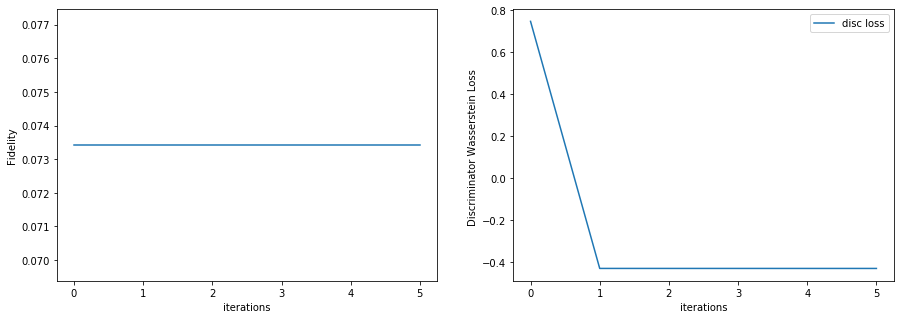

<IPython.core.display.Javascript object>

CPU times: user 3min 38s, sys: 3min 8s, total: 6min 46s
Wall time: 51.3 s


In [21]:
%%time
%%notify

n = 1 

for h in range(1):

    real_weights = np.random.uniform(0,2,3)
    init_gen_weights = np.random.uniform(0,2,3)
    init_disc_weights = np.random.uniform(0,2,8)

    gen_weights = init_gen_weights 
    disc_weights = init_disc_weights 

    real_circ, real_sv = real(n, real_weights)
    gen_circ, gen_sv = generator(n, gen_weights)

    fid = fidelity(real_sv, gen_sv)

    f = []
    dloss= []
    gloss = []

    f.append(fid)
    dloss.append(disc_loss(disc_weights))
    gloss.append(gen_loss(gen_weights))

    for i in range(5):

        disc_result = minimize(disc_loss, disc_weights, method = 'Powell') 
        disc_weights = disc_result.x
        dloss.append(float(disc_result.fun))


        f.append(fidelity(real_sv, gen_sv))



    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    y = f
    x = list(range(len(f)))

    y1 = dloss
    
    x1 = x 


    ax1.plot(x,y)
    ax2.plot(x1, y1, label = "disc loss")
    ax2.legend()


    ax1.set_xlabel('iterations')
    ax1.set_ylabel('Fidelity')
    ax2.set_xlabel('iterations')
    ax2.set_ylabel('Discriminator Wasserstein Loss ')



/home/zohim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/zohim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/zohim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/zohim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/zohim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, ord

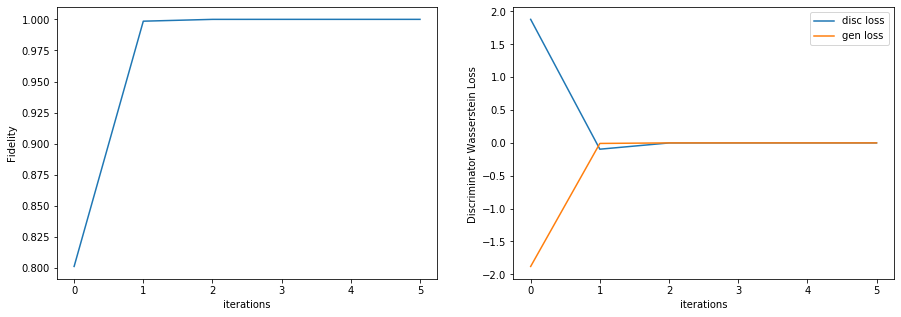

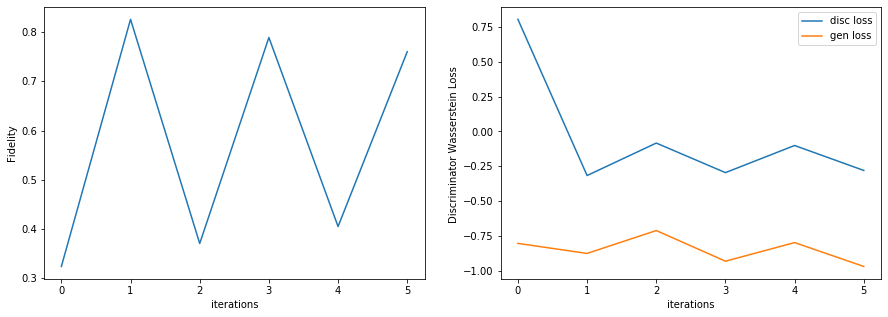

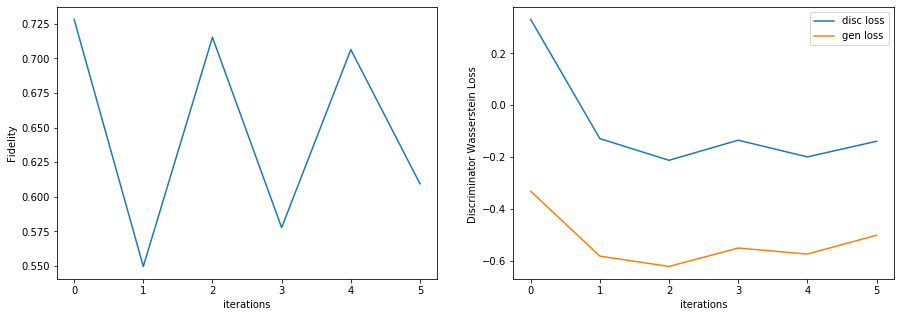

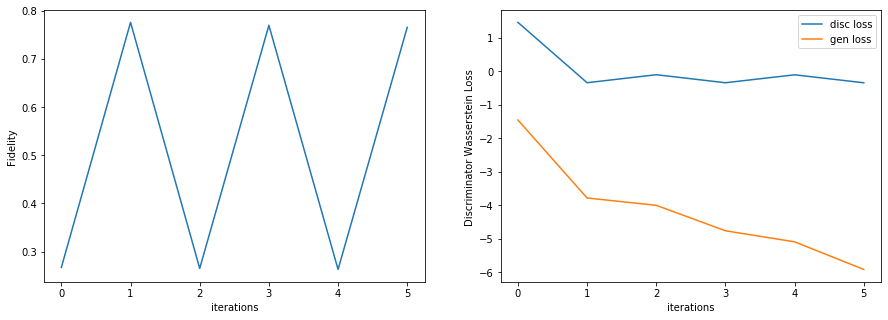

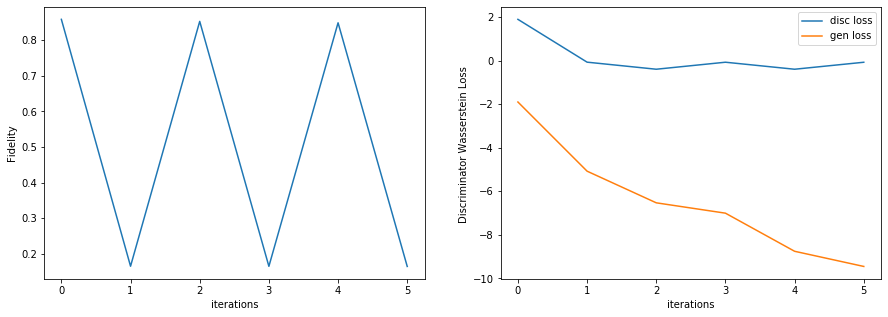

<IPython.core.display.Javascript object>

CPU times: user 30min 23s, sys: 25min 35s, total: 55min 58s
Wall time: 7min 2s


In [6]:
%%time
%%notify

n = 1 

for h in range(5):

    real_weights = np.random.uniform(0,2,3)
    init_gen_weights = np.random.uniform(0,2,3)
    init_disc_weights = np.random.uniform(0,2,8)

    gen_weights = init_gen_weights 
    disc_weights = init_disc_weights 

    real_circ, real_sv = real(n, real_weights)
    gen_circ, gen_sv = generator(n, gen_weights)

    fid = fidelity(real_sv, gen_sv)

    f = []
    dloss= []
    gloss = []

    f.append(fid)
    dloss.append(disc_loss(disc_weights))
    gloss.append(gen_loss(gen_weights))

    for i in range(5):

        disc_result = minimize(disc_loss, disc_weights, method = 'Powell') 
        disc_weights = disc_result.x
        dloss.append(float(disc_result.fun))

        gen_result = minimize(gen_loss, gen_weights, method = 'Powell') 
        gen_weights = gen_result.x
        gloss.append(float(gen_result.fun))

        gen_circ, gen_sv = generator(n, gen_weights)

        f.append(fidelity(real_sv, gen_sv))



    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    y = f
    x = list(range(len(f)))

    y1 = dloss

    y2 = gloss

    x1 = x 
    x2 = x

    ax1.plot(x,y)
    ax2.plot(x1, y1, label = "disc loss")
    ax2.plot(x2, y2, label = "gen loss")
    ax2.legend()


    ax1.set_xlabel('iterations')
    ax1.set_ylabel('Fidelity')
    ax2.set_xlabel('iterations')
    ax2.set_ylabel('Discriminator Wasserstein Loss ')



In [14]:
n = 1 

real_weights = [0, 1, 0]
init_gen_weights = [0, 0, 0]
init_disc_weights = np.random.uniform(0,2,8)


gen_weights = init_gen_weights 
disc_weights = init_disc_weights 

real_circ, real_sv = real(n, real_weights)
gen_circ, gen_sv = generator(n, gen_weights)

fid = fidelity(real_sv, gen_sv)


gen_angles = np.linspace(0, 1, 10)

f = []
dloss= []
gloss = []

for i in range(len(gen_angles)):
    
    disc_result = minimize(disc_loss, disc_weights, method = 'Powell') 
    disc_weights = disc_result.x
    dloss.append(float(disc_result.fun))
    
    
    gen_weights = [0, gen_angles[i], 0]
    gen_circ, gen_sv = generator(n, gen_weights)
    gloss.append(gen_loss(gen_weights))
        
    gen_circ, gen_sv = generator(n, gen_weights)
    
    f.append(fidelity(real_sv, gen_sv))
  


/home/zohim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Discriminator Wasserstein  Loss for disc weights = 1')

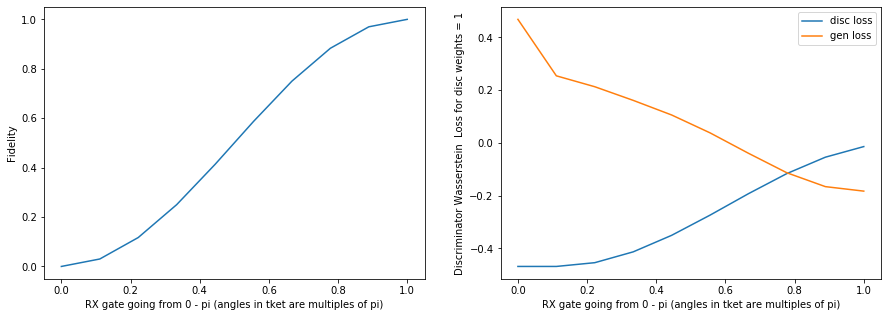

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))


y = f
x = gen_angles

y1 = dloss
x1 = gen_angles

y2 = gloss
x2 = gen_angles

ax1.plot(x,y)
ax2.plot(x1, y1, label = "disc loss")
ax2.plot(x2, y2,  label = "gen loss")
ax2.legend()


ax1.set_xlabel('RX gate going from 0 - pi (angles in tket are multiples of pi)')
ax1.set_ylabel('Fidelity')

ax2.set_xlabel('RX gate going from 0 - pi (angles in tket are multiples of pi)')
ax2.set_ylabel('Discriminator Wasserstein  Loss for disc weights = 1')


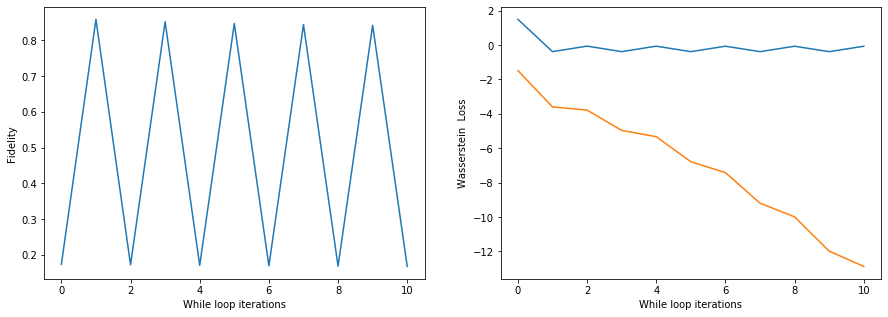

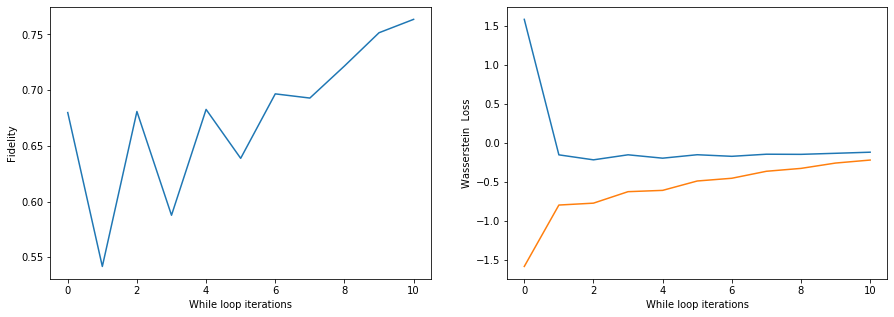

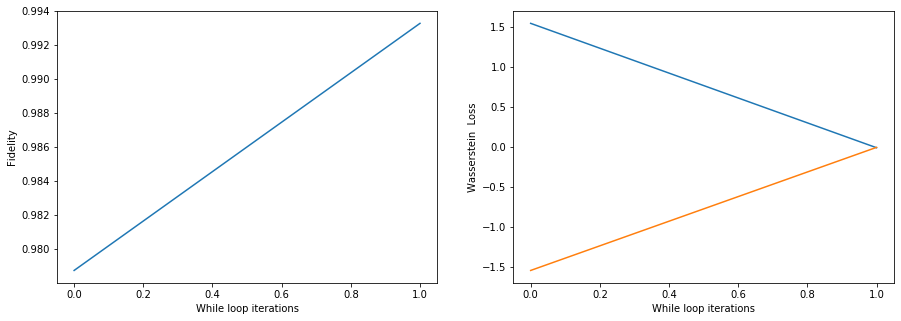

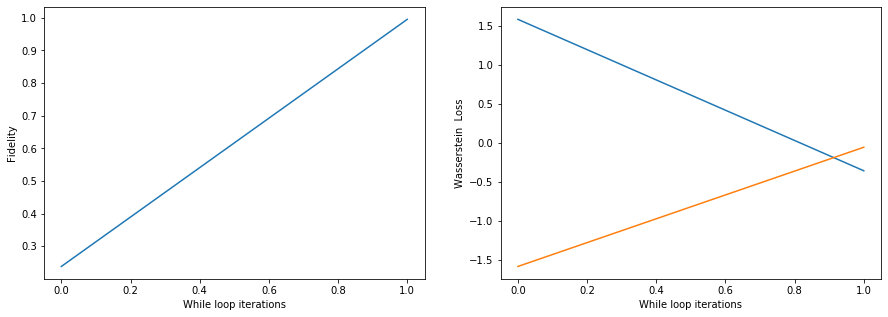

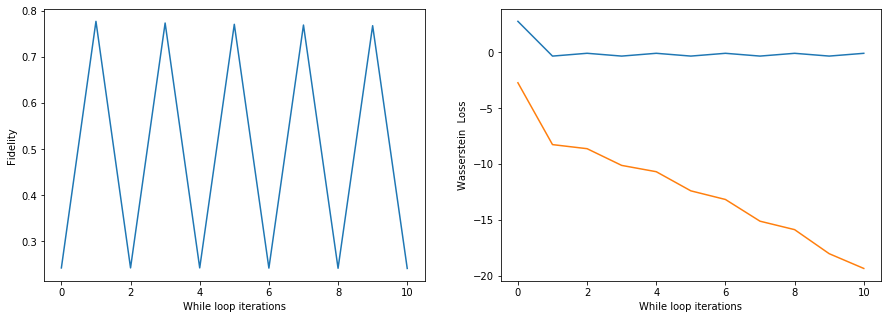

<IPython.core.display.Javascript object>

CPU times: user 45min 19s, sys: 38min 4s, total: 1h 23min 23s
Wall time: 10min 28s


In [19]:
%%time
%%notify


for r in range(5):

    real_weights = np.random.uniform(0,2,3)
    init_gen_weights = np.random.uniform(0,2,3)
    init_disc_weights = np.random.uniform(0,2,8)
    

    gen_weights = init_gen_weights
    disc_weights = init_disc_weights


    real_circ, real_sv = real(n, real_weights)
    gen_circ, gen_sv = generator(n, init_gen_weights)
    init_fid = fidelity(real_sv, gen_sv)

    fid = init_fid


    dloss = []
    gloss = []
    f = []
    
    f.append(init_fid)
    dloss.append(disc_loss(disc_weights))
    gloss.append(gen_loss(gen_weights))

    niter = 0 
    while fid <0.99:

        
        disc_result = minimize(disc_loss, disc_weights, method='Powell',  options={ 'maxiter': 1000})
        disc_weights = disc_result.x
        dloss.append(float(disc_result.fun))

        
        gen_result = minimize(gen_loss, gen_weights, method='Powell', options={ 'maxiter': 300})
        gen_weights = gen_result.x
        gloss.append(float(gen_result.fun))

        gen_circ, gen_sv = generator(n, gen_weights)
        
        fid = fidelity(real_sv, gen_sv)

        f.append(fid)

        niter += 1

        if niter == 10:
            break 

            
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))


    y = np.real(f)
    x =list(range(0, len(y)))

    y1 = dloss
    x1 =list(range(0, len(y1)))
    
    y2 = gloss
    x2 =list(range(0, len(y2)))


    ax1.plot(x,y)
    ax2.plot(x1, y1, label = "disc loss")
    ax2.plot(x2, y2,  label = "gen loss")


    ax1.set_xlabel('While loop iterations')
    ax1.set_ylabel('Fidelity')

    ax2.set_xlabel('While loop iterations')
    ax2.set_ylabel('Wasserstein  Loss')